<a href="https://colab.research.google.com/github/jytheodora/Gurobi_Study/blob/main/02_Workforce_Scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   인력 할당과 스케쥴링 - 시간에 따라 변화 / 시간 고정
*   변화하는 인력에 따라 자원 수요 충당하기 위해 일정 배치 / 이동



In [ ]:
%pip install gurobipy

     |████████████████████████████████| 11.1 MB 4.7 MB/s 


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import random


import pandas as pd
from pylab import *
import matplotlib
import matplotlib.pyplot as plt

# 각 날짜별로 필요한 시간을 배정한다.
1일차에는 6칸 근무 (6시간 근무 필요)


In [ ]:
shifts, shiftRequirements = gp.multidict({
  "1d":  6,
  "2d":  8,
  "3d":  10,
  "4d":  8,
  "5d":  8,
  "6d":  10,
  "7d":  2,
  "8d":  4,
  "9d":  11,
  "10d": 7,
  "11d": 5,
  "12d": 8,
  "13d": 7,
  "14d": 10 })

# 근무자별로 일할 수 있는 시간 배정

In [ ]:
# Amount each worker is paid to work one shift.
workers, pay = gp.multidict({
  "A": 10,
  "B": 12,
  "C": 10,
  "D": 8,
  "E": 8,
  "F": 9,
  "G": 11 })

### Set
근무자가 근무할수있는 요일날짜



In [ ]:
# Worker availability: defines on which day each employed worker is available.

availability = gp.tuplelist([
('A', '2d'), ('A', '3d'), ('A', '5d'), ('A', '7d'),
('A', '9d'), ('A', '10d'), ('A', '11d'), ('A', '12d'),
('A', '13d'), ('A', '14d'), ('B', '1d'), ('B', '2d'),
('B', '5d'), ('B', '6d'), ('B', '8d'), ('B', '11d'),
('B', '13d'), ('C', '3d'), ('C', '4d'), ('Cd', '5d'),
('C', '7d'), ('C', '8d'), ('C', '9d'), ('C', '10d'),
('C', '11d'), ('C', 'F12d'), ('C', '13d'),
('C', '14d'), ('D', '2d'), ('D', '3d'), ('D', '5d'),
('D', '6d'), ('D', '8d'), ('D', '9d'), ('D', '10d'),
('D', '11d'), ('D', '12d'), ('D', '13d'), ('D', '14d'),
('E', '1d'), ('E', '2d'), ('E', '3d'), ('Ed', '4d'),
('E', '5d'), ('E', '7d'), ('E', '8d'), ('Ed', '9d'),
('E', '11d'), ('E', '13d'), ('E', '14d'), ('F', '1d'),
('F', '2d'), ('F', '3d'), ('F', '6d'), ('F', '8d'),
('F', '9d'), ('F', '12d'), ('F', '13d'), ('F', '14d'),
('G', 'd1'), ('Gu', '2d'), ('G', '3d'), ('G', '5d'),
('G', '6d'), ('Gu', '7d'), ('G', '8d'), ('G', '9d'),
('G', '10d'), ('Gu', '11d'), ('G', '12d'), ('G', '13d'),
('G', '14d')
])

## Model Deployment

In [ ]:
# Create initial model.
m = gp.Model("workforce5")

Restricted license - for non-production use only - expires 2022-01-13


### Decision Variables

근무요일별로 근무시간이 정해져 있음
1일차 - 6시간 -> 근무할수 있는 사람별로 정해진 날짜가 있음
그리고 근무하는 사람별로 총 일할 수 있는 시간이 있음

In [ ]:
# Initialize assignment decision variables.

x = m.addVars(availability, vtype=GRB.BINARY, name="x") #할당 최화

In [ ]:
# Slack decision variables determine the number of extra workers required to satisfy the requirements 
# of each shift
slacks = m.addVars(shifts, name="Slack") 
#- 의사ㅕㄹ정변수
# 이 변수에 따라 추ㅏ 자업 요ㅜ  - 임시ㅡㄴ무자 필요?

### Auxiliary Variables
보조 변수는 의사 결정 변수의 값에서 파생됩니다.

$totSlack$: 교대 근무자의 수요를 충족하는 데 필요한 추가 근무자의 총 수

\text{tot}Shifts}(w)$:각 작업자 $w \in workers$가 작업한 총 작업 교대 수를 계산

\text{minShift}$: 근로자에게 할당되는 최소 교대 수를 결정합

\text{maxShift}$: 근로자에게 할당되는 최대 교대조 수를 결정

In [ ]:
# Auxiliary variable totSlack to represent the total number of extra workers required to satisfy the 
# requirements of all the shifts.
totSlack = m.addVar(name='totSlack')

In [ ]:
# Auxiliary variable totShifts counts the total shifts worked by each employed worker
totShifts = m.addVars(workers, name="TotShifts")

### Constraint

$$\sum_{w \: \in \: workers} x(w,s) \; + \; Slack(s) \; = \; \text{shiftRequirements}(s) \; \; \; \forall \; s \in shifts $$

In [ ]:
# Constraint: All shifts requirements most be satisfied.

shift_reqmts = m.addConstrs((x.sum('*',s) + slacks[s] == shiftRequirements[s] for s in shifts), name='shiftRequirement')


### Constraint

$$ \sum_{s \: \in \: shifts} Slack(s) \; = \; totSlack  $$

In [ ]:
# Constraint: set the auxiliary variable (totSlack) equal to the total number of extra workers 
# required to satisfy shift requirements
 
num_temps = m.addConstr(totSlack == slacks.sum(), name='totSlack')


### Constraint

$$\sum_{s \: \in \: shifts} x(w,s) \; = \; \text{totShifts}(w) \; \; \forall \ w \; in \; workers$$

In [ ]:
# Constraint: compute the total number of shifts for each worker

num_shifts = m.addConstrs((totShifts[w] == x.sum(w,'*') for w in workers), name='totShifts')


The variable $\text{minShift}$ determines the minimum numbers of shifts allocated to workers. This variable is calculated as follows:
$\text{minShift} = Min \{\text{totShifts}(w): \ w \; in \; workers \} $

The variable $\text{maxShift}$ determines the maximum numbers of shifts allocated to workers. This variable is calculated as follows:
$\text{maxShift} = Max \{\text{totShifts}(w): \ w \; in \; workers \} $

In [ ]:
# Auxiliary variables. 
# minShift is the minimum number of shifts allocated to workers 
# maxShift is the maximum number of shifts allocated to workers

minShift = m.addVar(name='minShift')

maxShift = m.addVar(name='maxShift')

# Constraint: 
# The addGenConstrMin() method of the model object m adds a new general constraint that 
# determines the minimum value among a set of variables. 
# The first argument is the variable whose value will be equal to the minimum of the other variables, 
# minShift in this case. 
# The second argument is the set variables over which the minimum will be taken, (totShifts) in 
# this case. 
# Recall that the totShifts variable is defined over the set of worker and determines the number of 
# shifts that an employed worker will work. The third argument is the name of this constraint.

min_constr = m.addGenConstrMin(minShift, totShifts, name='minShift')

# Constraint: 
# Similarly, the addGenConstrMax() method of the model object m adds a new general 
# constraint that determines the maximum value among a set of variables.

max_constr = m.addGenConstrMax(maxShift, totShifts, name='maxShift')


We have a primary and a secondary objective which both aim to minimize.

In [ ]:
# Set global sense for ALL objectives.
# This means that all objectives of the model object m are going to be minimized
m.ModelSense = GRB.MINIMIZE

## Objective Function

The primary objective is to minimize the total number of extra workers required to satisfy shift requirements. 
$$
\text{Min} \; totSlack \; = \; \sum_{s \: \in \: shifts} Slack(s) 
$$

For this objective we allow a degradation tolerance of up to certain percentage. If reltol = 0.2, then we allow a degradation
tolerance of 20%. 

In [ ]:
# Set up primary objective.

# The setObjectiveN() method of the model object m allows to define multiple objectives.
# The first argument is the linear expression defining the most important objective, called primary 
# objective, in this case it is the minimization of extra workers required to satisfy shift 
# requirements. 
# The second argument is the index of the objective function, we set the index of the primary 
# objective to be equal to 0. 
# The third argument is the priority of the objective.
# The fourth argument is the relative tolerance to degrade this objective when a lower priority
# objective is optimized. The fifth argument is the name of this objective.
# A hierarchical or lexicographic approach assigns a priority to each objective, and optimizes 
# for the objectives in decreasing priority order. 
# For this problem, we have two objectives, and the primary objective has the highest priority 
# which is equal to 2. 
# When the secondary objective is minimized, since the relative tolerance is 0.2, we can only 
# increase the minimum number of extra workers up to 20%. 
# For example if the minimum number extra workers is 10, then when optimizing the secondary objective 
# we can have up to 12 extra workers.

m.setObjectiveN(totSlack, index=0, priority=2, reltol=0.2, name='TotalSlack')

The secondary objective is to balance workload among workers. To do so, we minimize the difference between the maximum 
number of shifts allocated to a worker, and the minimum number of shifts allocated to a worker. That is
$$
\text{Min} \; (\text{maxShift}  -  \text{minShift}) 
$$ 

In [ ]:
# Set up secondary objective.

# The secondary objective is called fairness and its goal is to balance the workload assigned 
# to the employed workers. 
# To balance the workload assigned to the employed workers, we can minimize the difference 
# between the maximum number of shifts assigned to an employed worker and the minimum number 
# of shifts assigned to an employed worker.

m.setObjectiveN(maxShift - minShift, index=1, priority=1, name='Fairness')

In [ ]:
# Save model formulation for inspection

m.write('workforce.lp')

In [ ]:
# Optimize
# This method runs the optimization engine to solve the MIP problem in the model object m
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 22 rows, 96 columns and 172 nonzeros
Model fingerprint: 0xcec46015
Model has 2 general constraints
Variable types: 24 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+01]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 4 rows and 16 columns
Presolve time: 0.00s
Presolved: 26 rows and 112 columns
---------------------------------------------------------------------------

Multi-objectives: op

In [ ]:
# The Status attribute  provides current optimization status of the model object m
# In workforce model, we check if the model is infeasible or unbounded and report this situation
status = m.Status
if status == GRB.Status.INF_OR_UNBD or status == GRB.Status.INFEASIBLE  or status == GRB.Status.UNBOUNDED:
    print('The model cannot be solved because it is infeasible or unbounded')
    sys.exit(0)
# If the optimization status of the model is not optimal for some other reason, we report that 
# situation.
if status != GRB.Status.OPTIMAL:
    print('Optimization was stopped with status ' + str(status))
    sys.exit(0)

                    KPI Value
0  Total slack required  46.0
--------------------------------------------------
Shifts
  Worker  Number of shifts
0      A          8.000000
1      B          7.000000
2      C          7.000000
3      D          8.000000
4      E          7.000000
5      F          7.000001
6      G          8.000000


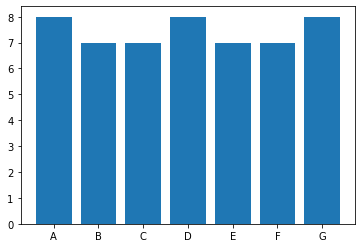

--------------------------------------------------
Assigments
Symbols: '-': not working, '*': working
  worker 1d 2d 3d 4d 5d 6d 7d 8d 9d 10d 11d 12d 13d 14d
0      A  -  *  -  -  *  -  -  -  *   *   *   *   *   -
1      B  *  *  -  -  *  *  -  *  -   -   *   -   *   -
2      C  -  -  *  *  -  -  -  -  *   *   -   -   *   *
3      D  -  *  *  -  -  -  -  -  *   *   -   *   *   *
4      E  *  *  *  -  *  -  *  *  -   -   *   -   -   -
5      F  *  *  *  -  -  -  -  -  *   -   -   *   *   *
6      G  -  -  *  -  *  *  -  -  *   *   -   -   *   *


In [ ]:
# Print total slack and the number of shifts worked for each worker
# The KPIs for this optimization number is the number of extra worked required to satisfy 
# demand and the number of shifts that each employed worker is working.
solution = {}
shifts_sol = {}
solution['Total slack required'] = str(totSlack.X)
assignments_all = {}
gant={}

assignments = dict()
for [w, s] in availability:
    if x[w, s].x == 1:
        if w in assignments:
            assignments[w].append(s)
        else:
            assignments[w] = [s]


print(pd.DataFrame.from_records(list(solution.items()), columns=['KPI', 'Value']))
print('-'*50)

for w in workers:
    shifts_sol[w]=totShifts[w].X
    assignments_all[w]=assignments.get(w, [])

print('Shifts')
print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['Worker', 'Number of shifts']))
    
y_pos = np.arange(len(shifts_sol.keys())) 
plt.bar(y_pos,shifts_sol.values() , align='center')
plt.xticks(y_pos, shifts_sol.keys())
plt.show()

print('-'*50)
for w in assignments_all:
    gant[w] = [w]
    for d in shifts:
        gant[w].append('*' if d in assignments_all[w] else '-')

print('Assigments')
print('Symbols: \'-\': not working, \'*\': working')
pd.set_option('display.width', 1000)
print(pd.DataFrame.from_records(list(gant.values()), columns=['worker']+shifts))

## Analysis

The total number of extra workers required to satisfy the shift requirements during the planning horizon is seven.

The bar chart shows the number of shifts that each employed worker will work during the planning horizon. Observe that with seven extra workers, the workload of employed workers is quite balanced.

The last table shows which day during the planning horizon each employed worker is working.

## Conclusion

In this Jupyter Notebook, we discussed a workforce scheduling optimization problem that is common in the services industry.
Consider a service business that develops its workforce plans for the next two weeks. There is only one shift per workday. Each shift may have different workers requirements on each workday. The service business may hire extra workers from an agency to satisfy shift requirements. The service business wants to minimize the number of extra workers that needs to hire, and as a secondary objective, it wants to balance the workload of employed workers.

The problem was formulated as a multi-objective mixed-integer-programming (MIP) model,
and implemented using the Gurobi Python API and solved using the Gurobi Optimizer.

The hierarchical  approach to tackling multi-objective function problems was explained in detail.


Copyright © 2020 Gurobi Optimization, LLC